In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from adjoint_esn.esn import ESN
from adjoint_esn.rijke_esn import RijkeESN
from adjoint_esn.utils import preprocessing as pp
from adjoint_esn.utils.enums import eParam, get_eVar
from pathlib import Path
from adjoint_esn.rijke_galerkin.solver import Rijke
from scipy.integrate import odeint
from adjoint_esn.utils import signals as sig
import adjoint_esn.utils.visualizations as vis
from adjoint_esn.utils import errors,scalers
from scipy import signal
from functools import partial
from src.configs.config import get_config
import yaml
from adjoint_esn.validation import set_ESN
from adjoint_esn.utils.discretizations import finite_differences

In [2]:
def load_config(experiment_path):
       with open(experiment_path/'config.yml', 'r') as file:
         config = yaml.unsafe_load(file)
         return config

experiment_path=Path('../local_results/rijke/run_20230923_074841') 
config = load_config(experiment_path)
results = pp.unpickle_file(experiment_path / 'results.pickle')[0]
print(config)
print(results)

model:
  connectivity: 0
  input_only_mode: true
  input_vars: eta_mu_v_tau
  input_weights_mode: sparse_grouped_rijke
  network_dt: 0.01
  output_vars: eta_mu
  param_vars:
  - beta
  r2_mode: false
  reservoir_size: 1200
  reservoir_weights_mode: erdos_renyi1
  type: rijke
  u_f_order: 1
  washout_time: 4
random_seed: 41
simulation:
  N_g: 4
  beta_list:
  - 1.0
  - 2.0
  - 3.0
  - 4.0
  - 5.0
  noise_level: 0
  sim_dt: 0.001
  sim_time: 800
  tau_list:
  - 0.1
  - 0.15
  - 0.2
  - 0.25
  - 0.3
  transient_time: 200
train:
  regime_selection: 20
  tikhonov: 0.001
  time: 200
val:
  error_measure: rmse
  fold_time: 4
  hyperparameters:
    input_scaling:
      max: 1.0
      min: 0.05
      scale: log10
    leak_factor:
      max: 1.0
      min: 0.1
      scale: uniform
    parameter_normalization_mean:
      beta:
        max: 10.0
        min: -10.0
        scale: uniform
    parameter_normalization_var:
      beta:
        max: 10.0
        min: 1.0
        scale: uniform
    tikho

## Data generation

In [3]:
# number of galerkin modes
N_g = config.simulation.N_g

# simulation options
sim_time = config.simulation.sim_time
sim_dt = config.simulation.sim_dt

# directory to search for simulation data, if the data doesn't exist, 
# then it will simulate the system
data_dir=Path('..\data')

# which regimes to use for training and validation
train_param_list = results["training_parameters"]
train_idx_list = np.arange(len(train_param_list))

transient_time = config.simulation.transient_time

noise_level = config.simulation.noise_level
random_seed = config.random_seed

# network time step
network_dt = config.model.network_dt

washout_time = config.model.washout_time

# which states to use as input and output
# for standard ESN these should be the same, e.g. both 'eta_mu'
# for Rijke ESN, input and output should be 'eta_mu_v_tau' and 'eta_mu' respectively
input_vars = config.model.input_vars
eInputVar = get_eVar(input_vars,N_g)
output_vars = config.model.output_vars
eOutputVar = get_eVar(output_vars,N_g)

# which system parameter is passed to the ESN
param_vars=config.model.param_vars

# if using Rijke ESN what is the order of u_f(t-tau) in the inputs,
# [u_f(t-tau), u_f(t-tau)^2 ..., u_f(t-tau)^(u_f_order)]
u_f_order = config.model.u_f_order

# length of training time series
train_time = config.train.time

loop_names=['train']
loop_times = [train_time]

DATA = {}
for loop_name in loop_names:
    DATA[loop_name]={'u_washout':[],'p_washout':[],'u':[],'p':[],'y':[],'t':[]}

for p_idx, p in enumerate(train_param_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    regime_data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        loop_names=loop_names,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order,
                        noise_level=noise_level,
                        random_seed=random_seed)
    
    for loop_name in loop_names:
        [DATA[loop_name][var].append(regime_data[loop_name][var]) for var in DATA[loop_name].keys()]

# dimension of the inputs
dim = DATA["train"]["u"][0].shape[1]

### Plot data

In [ ]:
len_p_list=len(train_param_list)
plt_idx = [eInputVar.eta_1,eInputVar.eta_2,eInputVar.mu_1,eInputVar.mu_2,eInputVar.v_tau]
for p_idx in range(len_p_list):
    plt.figure(figsize = (15,3),constrained_layout=True)
    for j, k in enumerate(plt_idx):
        plt.subplot(1,len(plt_idx),j+1)
        vis.plot_lines(DATA["train"]["t"][p_idx],DATA["train"]["u"][p_idx][:,k],
                   title=f"beta = {train_param_list[p_idx][eParam.beta]}, tau = {train_param_list[p_idx][eParam.tau]},",
                   xlabel='t',
                   ylabel=k.name)
        plt.xlim([washout_time,20+washout_time])

## Train ESN

In [4]:
def create_ESN(ESN_dict, model_type, hyp_param_names, hyp_param_scales, hyp_params):
    if model_type == 'standard':
        my_ESN = ESN(**ESN_dict)
    elif model_type == 'rijke':
        my_ESN = RijkeESN(**ESN_dict)
    set_ESN(my_ESN,hyp_param_names,hyp_param_scales,hyp_params)
    return my_ESN

In [5]:
ESN_dict = {
        "reservoir_size": config.model.reservoir_size,
        "parameter_dimension": len(param_vars),
        "reservoir_connectivity": config.model.connectivity,
        "r2_mode": config.model.r2_mode,
        "input_only_mode": config.model.input_only_mode,
        "input_weights_mode": config.model.input_weights_mode,
        # "reservoir_weights_mode": config.model.reservoir_weights_mode,
        "tikhonov": config.train.tikhonov,
    }
if config.model.type == "standard":
    ESN_dict["dimension"] = dim
elif config.model.type == "rijke":
    ESN_dict["N_g"] = config.simulation.N_g
    ESN_dict["x_f"] = 0.2
    ESN_dict["dt"] = config.model.network_dt
    ESN_dict["u_f_order"] = config.model.u_f_order

print('System dimension: ', dim)

top_idx = 0
hyp_param_names = []
hyp_params = []
for name in results.keys():
    if name not in ['training_parameters','validation_parameters','f','tikh']:
        if results[name].ndim == 2:
            hyp_param_names.extend([name]*results[name].shape[1])
            hyp_params.extend(results[name][top_idx])
        elif results[name].ndim == 1:
            hyp_param_names.extend([name])
            hyp_params.extend([results[name][top_idx]])
        
hyp_param_scales = ['uniform']*len(hyp_param_names)
my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)

System dimension:  9
Input normalization is changed, training must be done again.
Parameter normalization is changed, training must be done again.
Input scaling is set to 1, set it separately if necessary.
Input weights are rescaled with the new input scaling.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.
Input weights of u_f(t-tau) are rescaled with the new input scaling.
Parameter normalization is changed, training must be done again.
Input weights are rescaled with the new input scaling.


In [6]:
my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)

In [49]:
u_washout_auto = DATA["train"]["u_washout"][0]
u_washout_auto = np.repeat(DATA["train"]["u_washout"][0][0,:][None,:], [len(DATA["train"]["u_washout"][0])], axis = 0)
y0 = np.zeros((1,2*N_g))
y0[0] = 1
u_washout_auto = np.repeat(y0, [len(DATA["train"]["u_washout"][0])], axis = 0)

## Test ESN

Regime: beta = 3.0, tau = 0.2, Error: 0.02792618408902659


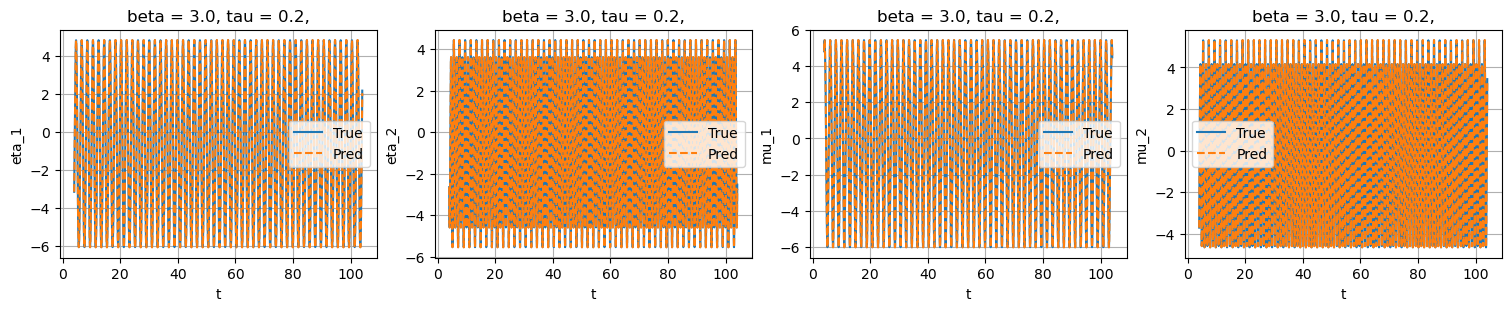

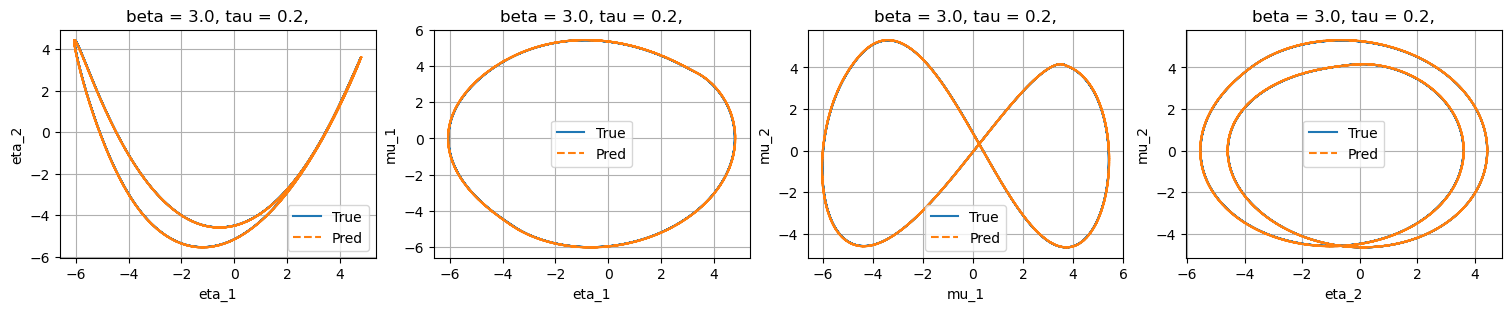

In [13]:
sim_time = 400
sim_dt = 1e-3
loop_times = [100]
beta_list = [3.0]
tau_list = [0.2]
plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]
plt_idx_pairs = [[eOutputVar.eta_1,eOutputVar.eta_2],
                 [eOutputVar.eta_1,eOutputVar.mu_1],
                 [eOutputVar.mu_1,eOutputVar.mu_2],
                 [eOutputVar.eta_2,eOutputVar.mu_2]]
phase_space_steps = pp.get_steps(8,network_dt)

error_measure = errors.rel_L2
p_list = pp.make_param_mesh([beta_list,tau_list])

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]},'

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_lines(data[loop_name]["t"],data[loop_name]["y"][:,k],y_pred[:,k],
                       title=regime_str,
                       xlabel='t',
                       ylabel=k.name,
                       linestyle=['-','--'],
                       legend=['True','Pred'])
            
        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx_pairs):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_phase_space(data[loop_name]["y"][-phase_space_steps:],
                             y_pred[-phase_space_steps:],
                             idx_pair=k,
                             title=regime_str,
                             linestyle=['-','--'],
                             legend=['True','Pred'])
            plt.xlabel(k[0].name)
            plt.ylabel(k[1].name)

        print('Regime:',regime_str,'Error:', error_measure(data[loop_name]["y"],y_pred))

## Statistics

In [ ]:
sim_time = 300
loop_times = [20]

beta_list = [5.5]
tau_list = [0.13,0.14,0.15,0.16,0.17]
p_list = pp.make_param_mesh([beta_list,tau_list])

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    for loop_name in data.keys():
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]
        regime_str = f"beta = {p_list[p_idx][eParam.beta]}, tau = {p_list[p_idx][eParam.tau]},"

        plt.figure(figsize = (15,3),constrained_layout=True)
        for j, k in enumerate(plt_idx):
            plt.subplot(1,len(plt_idx),j+1)
            vis.plot_statistics(data[loop_name]["y"][:,k],y_pred[:,k],
                                title=regime_str,
                                xlabel=k.name,
                                ylabel='PDF',
                                linestyle=['-','--'],
                                legend=['True','Pred'])

## Stability analysis

In [16]:
import adjoint_esn.utils.lyapunov as lyap
from adjoint_esn.rijke_galerkin.solver import Rijke

sim_time = 500
sim_dt = 1e-3
loop_times = [120]

p_sim = {'beta':3.0, 'tau':0.2}

rjk = Rijke(
    N_g=4,
    N_c=10,
    c_1=0.1,
    c_2=0.06,
    beta=p_sim["beta"],
    x_f=0.2,
    tau=p_sim["tau"],
    heat_law='kings_poly',
    damping='modal',
)
y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                            sim_time=sim_time,sim_dt=sim_dt,
                            data_dir=data_dir)
N_transient = pp.get_steps(transient_time,sim_dt)
y_bar = y_sim[N_transient:,:]
t_bar = t_sim[N_transient:]

N_washout = pp.get_steps(washout_time,sim_dt)
N_loop = pp.get_steps(loop_times[0],sim_dt)+1
y_bar = y_bar[N_washout:N_washout + N_loop,:]
t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]
y_bar = y_bar[:,:rjk.N_dim]

data = pp.create_dataset(y_sim,t_sim,p_sim,
                    network_dt=network_dt,
                    transient_time=transient_time,
                    washout_time=washout_time,
                    loop_times=loop_times,
                    input_vars=input_vars,
                    output_vars=output_vars,
                    param_vars=param_vars,
                    N_g=N_g,
                    u_f_order=u_f_order)

if hasattr(my_ESN,"tau"):
    my_ESN.tau = p_sim["tau"]
for loop_name in data.keys():
    X_pred, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])

# LEs_true, FTLE_true, QQ_true, RR_true = lyap.calculate_LEs(sys=rjk,
#                                  sys_type='continuous',
#                                  X=y_bar,
#                                  t=t_bar,
#                                  transient_time=100,
#                                  dt=sim_dt,
#                                  target_dim=None,
#                                  norm_step=1)
# LEs_target = LEs_true[-1]
# print('Lyapunov exponents true:', LEs_target)
# print('Lyapunov time true:', 1/LEs_target[0])
# # CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

LEs, FTLE, QQ, RR = lyap.calculate_LEs(sys=my_ESN,
                                 sys_type='ESN',
                                 X=X_pred,
                                 t=data[loop_name]["t"]-data[loop_name]["t"][0],
                                 transient_time=100,
                                 dt=network_dt,
                                 target_dim=my_ESN.N_dim,
                                 norm_step=1)
LEs_target = LEs[-1]
print('Lyapunov exponents:', LEs_target)
print('Lyapunov time:', 1/LEs_target[0])
# CLVs, angles, FTCLE = lyap.calculate_CLVs(QQ,RR,dt)

Lyapunov exponents: [ -0.07917253  -0.0807821   -0.24358786  -0.242353    -0.51124914
  -0.51281914  -0.91703045  -0.91391905 -10.53605179]
Lyapunov time: -12.63064324198399


## Bifurcation diagram

In [ ]:
sim_time = 300
loop_times = [100]

beta_list = np.arange(0.5,9.0,0.1)
tau_list = [0.2]

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

plt_idx = [eOutputVar.eta_1,eOutputVar.eta_2,eOutputVar.mu_1,eOutputVar.mu_2]

fig, ax = plt.subplots(nrows=2, 
                        ncols=len(plt_idx), 
                        figsize=(15,5), 
                        constrained_layout=True)

# track minimum and maximum values of the peaks 
pks_min = np.inf*np.ones((len(p_list),len(plt_idx)))   
pks_max = -np.inf*np.ones((len(p_list),len(plt_idx)))   

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p_sim["tau"]
    
    _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                N_t=len(data[loop_name]["u"]), 
                                                P_washout=data[loop_name]["p_washout"],  
                                                P=data[loop_name]["p"])
    y_pred = y_pred[1:]

    for j, k in enumerate(plt_idx):
        plt.sca(ax[0,j])
        pks_true = vis.plot_bifurcation_diagram(p_sim[vary_param], data[loop_name]["y"][:,k], 
                                        color='tab:blue', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_true = np.min(pks_true)
        max_pks_true = np.max(pks_true)

        plt.sca(ax[1,j])
        pks_pred = vis.plot_bifurcation_diagram(p_sim[vary_param], y_pred[:,k],
                                        color='tab:orange', 
                                        marker='*', 
                                        linestyle='None')
        min_pks_pred = np.min(pks_pred)
        max_pks_pred = np.max(pks_pred)

        pks_min[p_idx,j] = min(pks_min[p_idx,j], min(min_pks_true,min_pks_pred))
        pks_max[p_idx,j] = max(pks_max[p_idx,j], max(max_pks_true,max_pks_pred))

for j, k in enumerate(plt_idx):
    for i in range(ax.shape[0]):
        ylims = [np.min(pks_min[:,j]),np.max(pks_max[:,j])]
        ax[i,j].set_ylim(ylims)
        ax[i,j].set_xlabel(vary_param)
        ax[i,j].set_ylabel(f"Local maxima of {k.name}")
        ax[i,j].vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
        ax[i,j].grid()

## Hopf bifurcation curve

In [33]:
def acoustic_energy(y, N_g):
    return 1/4*np.mean(np.sum(y[:,:2*N_g]**2, axis = 1))

In [ ]:
sim_time = 300
loop_times = [100]

beta_list = np.arange(0.2,2.5,0.1)
tau_list = np.arange(0.05,0.4,0.01)

def energy_decreased(y, N_g, percent_threshold = 5):
    half_steps = int(np.round(len(y)/2))
    e1 = acoustic_energy(y[:half_steps],N_g)
    e2 = acoustic_energy(y[half_steps:],N_g)
    return e1-e2 > (percent_threshold/100)*e1

percent_threshold = 5
p_energy_decreased = partial(energy_decreased, N_g=N_g, percent_threshold=percent_threshold)
bifn_point_true = np.zeros(len(tau_list))
bifn_point_pred = np.zeros(len(tau_list))

for tau_idx, tau in enumerate(tau_list):
    for beta_idx, beta in enumerate(beta_list): 
        p_sim = {'beta':beta, 'tau':tau}
        y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                    sim_time=sim_time,sim_dt=sim_dt,
                                    data_dir=data_dir)

        data = pp.create_dataset(y_sim,t_sim,p_sim,
                            network_dt=network_dt,
                            transient_time=transient_time,
                            washout_time=washout_time,
                            loop_times=loop_times,
                            input_vars=input_vars,
                            output_vars=output_vars,
                            param_vars=param_vars,
                            N_g=N_g,
                            u_f_order=u_f_order)
        
        loop_name = list(data.keys())[0]

        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]
        
        _, y_pred = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"], 
                                                    N_t=len(data[loop_name]["u"]), 
                                                    P_washout=data[loop_name]["p_washout"],  
                                                    P=data[loop_name]["p"])
        y_pred = y_pred[1:]

        if p_energy_decreased(data[loop_name]["y"]):
            bifn_point_true[tau_idx] = beta

        if p_energy_decreased(y_pred):
            bifn_point_pred[tau_idx] = beta

        if not p_energy_decreased(data[loop_name]["y"]) and not p_energy_decreased(y_pred):
            break
        
plt.figure(figsize=(5,5))
vis.plot_reverse_lines(bifn_point_true,bifn_point_pred,y=tau_list,
                       linestyle=['-','--'],
                       xlabel='beta',
                       ylabel='tau')

## Sensitivity

In [34]:
def true_direct_sensitivity(my_rijke, t_bar, y_bar):
    dt = t_bar[1]-t_bar[0]
    # direct problem
    dir0 = np.zeros(2*my_rijke.N_dim+2)
    dir = odeint(my_rijke.direct_ode,dir0,t_bar,args=(t_bar,1/dt,y_bar),tfirst= True)
    dJdp = 1/t_bar[-1]*dir[-1,-2]
    return dJdp

def true_adjoint_sensitivity(my_rijke, t_bar, y_bar):
    dt = t_bar[1]-t_bar[0]
    # adjoint problem
    adjT = np.zeros(my_rijke.N_dim+2)
    adj = odeint(my_rijke.adjoint_ode,adjT,np.flip(t_bar),args =(t_bar,1/dt,y_bar),tfirst= True)
    dJdp  = 1/t_bar[-1]*adj[-1,-2:]
    return dJdp

def true_finite_difference_sensitivity(my_rijke, t_bar, y_bar, h, h_tau, method):
    # Calculate numerically
    # Find perturbed solutions (in beta)
    dJdp = np.zeros((2,))

    # left solution with beta = beta-h
    my_rijke_beta_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta-h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_beta_left = odeint(my_rijke_beta_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_left = acoustic_energy(y_bar_beta_left[1:,:], my_rijke.N_g)
        
    # right solution with beta = beta+h
    my_rijke_beta_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta+h,x_f=my_rijke.x_f,tau=my_rijke.tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_beta_right = odeint(my_rijke_beta_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_beta_right = acoustic_energy(y_bar_beta_right[1:,:], my_rijke.N_g)

    # left solution with tau = tau-h
    my_rijke_tau_left = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau-h_tau,
                     heat_law="kings_poly",damping="modal")

    y_bar_tau_left = odeint(my_rijke_tau_left.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_left = acoustic_energy(y_bar_tau_left[1:,:], my_rijke.N_g)
        
    # # right solution with tau = tau+h
    my_rijke_tau_right = Rijke(N_g=my_rijke.N_g,N_c=my_rijke.N_c,c_1=0.1,c_2=0.06,beta=my_rijke.beta,x_f=my_rijke.x_f,tau=my_rijke.tau+h_tau,
                     heat_law="kings_poly",damping="modal")
    
    y_bar_tau_right = odeint(my_rijke_tau_right.ode,y_bar[0,:],t_bar,tfirst = True)
    J_tau_right = acoustic_energy(y_bar_tau_right[1:,:], my_rijke.N_g)

    # define which finite difference method to use
    finite_difference = partial(finite_differences, method=method)

    J = acoustic_energy(y_bar[1:,:],my_rijke.N_g)
    dJdp[eParam.beta] = finite_difference(J, J_beta_right, J_beta_left, h)
    dJdp[eParam.tau] = finite_difference(J, J_tau_right, J_tau_left, h_tau)
    return dJdp


In [35]:
n_esns = 1
# generate and train ESN realisations
ESN_list = [None]*n_esns
ESN_dict["verbose"] = False
for esn_idx in range(n_esns):
    ESN_dict["input_seeds"] = [3*esn_idx, 3*esn_idx+1, 3*esn_idx+2]
    if not config.model.input_only_mode:
        ESN_dict["reservoir_seeds"] = [100+2*esn_idx, 101+2*esn_idx]
    my_ESN = create_ESN(ESN_dict, config.model.type, hyp_param_names, hyp_param_scales, hyp_params)
    my_ESN.train(DATA["train"]["u_washout"], 
             DATA["train"]["u"], 
             DATA["train"]["y"],
             P_washout=DATA["train"]["p_washout"], 
             P_train=DATA["train"]["p"],
             train_idx_list=train_idx_list)
    ESN_list[esn_idx] = my_ESN

In [43]:
sim_time = 1000
loop_times = [900]

beta_list =[6.0,7.0]
tau_list = [0.2]

if len(beta_list) > 1 and len(tau_list) == 1:
    vary_param = 'beta'
elif len(beta_list) == 1 and len(tau_list) > 1:
    vary_param = 'tau'
else:
    raise ValueError("For this plot one parameter needs to be varying and the other fixed.")
p_list = pp.make_param_mesh([beta_list,tau_list])

vary_param_train = list(set(train_param_list[train_idx_list,eParam[vary_param]]))

finite_difference_method = 'central'
methods = ['numerical']
dJdp = {'true':{},'esn':{}}
for method_name in methods:
    dJdp['true'][method_name] = np.zeros((len(p_list),2))
    if config.model.type == 'standard':
        dJdp['esn'][method_name] = np.zeros((n_esns,len(p_list),len(param_vars)))
    elif config.model.type == 'rijke':
        dJdp['esn'][method_name] = np.zeros((n_esns,len(p_list),2))

J = {'true':np.zeros(len(p_list)),'esn':np.zeros((n_esns,len(p_list)))}

for p_idx, p in enumerate(p_list):
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    print('Regime:',regime_str)
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    N_transient = pp.get_steps(transient_time,sim_dt)
    y_bar = y_sim[N_transient:,:]
    t_bar = t_sim[N_transient:]

    N_washout = pp.get_steps(washout_time,sim_dt)
    N_loop = pp.get_steps(loop_times[0],sim_dt)+1
    y_bar = y_bar[N_washout:N_washout + N_loop,:]
    t_bar = t_bar[N_washout:N_washout + N_loop]-t_bar[N_washout]

    my_rijke = Rijke(
            N_g=N_g,
            N_c=10,
            c_1=0.1,
            c_2=0.06,
            beta=p_sim["beta"],
            x_f=0.2,
            tau=p_sim["tau"],
            heat_law="kings_poly",
            damping="modal",
        )
    # NOTE: because of downsampling, e.g. sim_dt = 1e-3, network_dt = 1e-2, y_bar[10] = data[loop_name]["y"][0]
    # how much does this, and downsampling overall, affect the accuracy?
    J["true"][p_idx] = acoustic_energy(y_bar[1:,:], N_g)
    for method_name in methods:
        if method_name == "direct":
            dJdp["true"][method_name][p_idx]= true_direct_sensitivity(my_rijke, t_bar, y_bar)
        elif method_name == "adjoint":
            dJdp["true"][method_name][p_idx]= true_adjoint_sensitivity(my_rijke, t_bar, y_bar)
        elif method_name == "numerical":
            dJdp["true"][method_name][p_idx]= true_finite_difference_sensitivity(my_rijke, t_bar, 
                                                                                 y_bar, 
                                                                                 h=1e-5, 
                                                                                 h_tau=network_dt, 
                                                                                 method=finite_difference_method)
        print(f'True dJ/dp, {method_name} = {dJdp["true"][method_name][p_idx]}')

    for esn_idx in range(n_esns):
        my_ESN = ESN_list[esn_idx]
         # Wash-out phase to get rid of the effects of reservoir states initialised as zero
        # initialise the reservoir states before washout
        x0_washout = np.zeros(my_ESN.N_reservoir)
        N = len(data[loop_name]["u"])

        # N_transient_ = pp.get_steps(transient_time, network_dt)
        if hasattr(my_ESN,"tau"):
            my_ESN.tau = p_sim["tau"]
            # let the ESN run in open-loop for the wash-out
            # get the initial reservoir to start the actual open/closed-loop,
            # which is the last reservoir state
            X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
            P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], data[loop_name]["p"]))
            X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)

            for method_name in methods:
                if method_name == "direct":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.direct_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
                elif method_name == "adjoint":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, X_tau)
                elif method_name == "numerical":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                                                                                Y_pred_grad, 
                                                                                                X_tau, 
                                                                                                P_grad, 
                                                                                                N, 
                                                                                                method=finite_difference_method)
                print(f'ESN {esn_idx} dJ/dp, {method_name} = {dJdp["esn"][method_name][esn_idx,p_idx]}')
        else:
            X_pred_grad, Y_pred_grad = my_ESN.closed_loop_with_washout(U_washout=data[loop_name]["u_washout"],
                                                                   N_t=N,
                                                                   P_washout=data[loop_name]["p_washout"],
                                                                   P=data[loop_name]["p"])
            # take out transient
            # X_pred_grad = X_pred_grad[N_transient_:,:]
            # Y_pred_grad = Y_pred_grad[N_transient_:,:]
            # N = len(data[loop_name]["u"])-N_transient_
            
            for method_name in methods:
                if method_name == "direct":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.direct_sensitivity(X_pred_grad, Y_pred_grad, N, N_g)
                elif method_name == "adjoint":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.adjoint_sensitivity(X_pred_grad, Y_pred_grad, N, N_g)                    
                elif method_name == "numerical":
                    dJdp["esn"][method_name][esn_idx,p_idx]= my_ESN.finite_difference_sensitivity(X=X_pred_grad, 
                                                                                        Y=Y_pred_grad,  
                                                                                        P=data[loop_name]["p"], 
                                                                                        N=N, 
                                                                                        N_g=N_g,
                                                                                        method=finite_difference_method)
                print(f'ESN {esn_idx} dJ/dp, {method_name} = {dJdp["esn"][method_name][esn_idx,p_idx]}')

        J["esn"][esn_idx, p_idx] = acoustic_energy(Y_pred_grad[1:,:], N_g)
        print(f'ESN J = {J["esn"][esn_idx, p_idx]}') 
            

Regime: beta = 6.0, tau = 0.2
True dJ/dp, numerical = [   0.36174413 -272.12260798]
ESN 0 dJ/dp, numerical = [ 2.24836738e-02 -4.71164292e+01]
ESN J = 19.010135778120546
Regime: beta = 7.0, tau = 0.2
True dJ/dp, numerical = [ 9920.29010144 -2572.72324903]
ESN 0 dJ/dp, numerical = [20.31449787 -7.51179661]
ESN J = 26.2301894598571


In [ ]:
dJdp_mean ={}
dJdp_std ={}
for method_name in methods:
    dJdp_mean[method_name] = np.mean(dJdp["esn"][method_name], axis=0)
    dJdp_std[method_name] = np.std(dJdp["esn"][method_name], axis=0)

linestyle = ['-']*len(methods)
linestyle.extend(['--']*len(methods))
marker = ['o']*len(methods)
marker.extend(['+']*len(methods))
markersize = [5]*len(methods)
markersize.extend([6]*len(methods))

color = ['tab:blue','tab:orange','tab:red','tab:green']
plt.figure(figsize = (12,8))

if hasattr(my_ESN,"tau"):
    param_list = eParam
else:
    param_list = [eParam[param] for param in param_vars]
for i in param_list:

    plt.subplot(2,2,i+1)
    vis.plot_lines(p_list[:,eParam[vary_param]],
                   *[dJdp["true"][method_name][:,i] for method_name in methods],
                   *[dJdp_mean[method_name][:,i] for method_name in methods],
                   linestyle=linestyle,
                   color=color,
                   marker=marker,
                   markersize=markersize
                   )
    
    for m_idx, method_name in enumerate(methods):
        plt.fill_between(p_list[:,eParam[vary_param]], 
                    dJdp_mean[method_name][:,i]-dJdp_std[method_name][:,i],
                    dJdp_mean[method_name][:,i]+dJdp_std[method_name][:,i],
                    alpha=0.2, 
                    antialiased=True,
                    color=color[len(methods)+m_idx])
    ax = plt.gca()
    ylims = ax.get_ylim()
    plt.vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')

    plt.xlabel(vary_param)
    plt.ylabel(f"dJ/d{i.name}")

plt.figure(figsize = (12,8))
for i in param_list:

    plt.subplot(2,2,i+1)
    error = [100
             *
             np.abs(dJdp_mean[method_name][:,i]-dJdp["true"][method_name][:,i])
             /
             np.abs(dJdp["true"][method_name][:,i]) 
             for method_name in methods]
    
    vis.plot_lines(p_list[:,eParam[vary_param]],
                   *error,
                   )
    ax = plt.gca()
    ylims = ax.get_ylim()
    plt.vlines(vary_param_train, ymin=ylims[0], ymax=ylims[1], color = "grey", linestyles='dashed')
    
    plt.xlabel(vary_param)
    plt.ylabel(f"% dJ/d{i.name} error")


 ## Optimization

In [2]:
energy_dict = pp.unpickle_file('../energy2.pickle')[0]

Text(0, 0.5, 'tau')

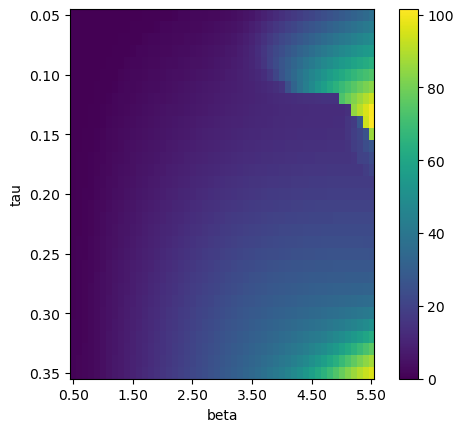

In [14]:
plt.imshow(energy_dict["J"].T,aspect=2)
plt.colorbar()

xticks = np.arange(0,len(energy_dict["beta_list"]),10)
xtick_idx = [int(xtick) for xtick in xticks]
xticklabels = energy_dict["beta_list"][xtick_idx]
xticklabels = [f"{xticklabel:.2f}" for xticklabel in xticklabels]
yticks = np.arange(0,len(energy_dict["tau_list"]),5)
ytick_idx = [int(ytick) for ytick in yticks]
yticklabels = energy_dict["tau_list"][ytick_idx]
yticklabels = [f"{yticklabel:.2f}" for yticklabel in yticklabels]

plt.xticks(xticks,labels=xticklabels)
plt.yticks(yticks,labels=yticklabels)

plt.xlabel('beta')
plt.ylabel('tau')

In [24]:
sim_time = transient_time + washout_time
loop_times = [0]
N = 10000

def J_and_dJdp(p, grad = False):
    global iter
    p_sim = {'beta':p[eParam.beta], 'tau':p[eParam.tau]}

    regime_str = f'beta = {p_sim["beta"]}, tau = {p_sim["tau"]}'
    iter +=1
    print(f'Iteration: {iter}, Regime: {regime_str}')
    
    y_sim, t_sim = pp.load_data(beta=p_sim["beta"],tau=p_sim["tau"],x_f=0.2,N_g=N_g,
                                sim_time=sim_time,sim_dt=sim_dt,
                                data_dir=data_dir)

    data = pp.create_dataset(y_sim,t_sim,p_sim,
                        network_dt=network_dt,
                        transient_time=transient_time,
                        washout_time=washout_time,
                        loop_times=loop_times,
                        input_vars=input_vars,
                        output_vars=output_vars,
                        param_vars=param_vars,
                        N_g=N_g,
                        u_f_order=u_f_order)
    
    loop_name = list(data.keys())[0]

    if hasattr(my_ESN,"tau"):
        my_ESN.tau = p[eParam.tau]

    # Wash-out phase to get rid of the effects of reservoir states initialised as zero
    # initialise the reservoir states before washout
    x0_washout = np.zeros(my_ESN.N_reservoir)

    # let the ESN run in open-loop for the wash-out
    # get the initial reservoir to start the actual open/closed-loop,
    # which is the last reservoir state
    X_tau = my_ESN.open_loop(x0=x0_washout, U=data[loop_name]["u_washout"], P=data[loop_name]["p_washout"])
    P_grad = data[loop_name]["p_washout"][0]*np.ones((N,1))
    P_grad = np.vstack((data[loop_name]["p_washout"][-my_ESN.N_tau - 1 :, :], P_grad))
    X_pred_grad, Y_pred_grad = my_ESN.closed_loop(X_tau[-my_ESN.N_tau - 1 :, :], N_t=N, P=P_grad)
    J = acoustic_energy(Y_pred_grad[1:,:], N_g)
    if not grad:
        print(f'J = {J}')
        return J
    else:
        dJdp=my_ESN.finite_difference_sensitivity(X_pred_grad, 
                                                Y_pred_grad, 
                                                X_tau, 
                                                P_grad, 
                                                N)
        # dJdp=my_ESN.adjoint_sensitivity(X_pred_grad, 
        #                                 Y_pred_grad, 
        #                                 N,
        #                                 X_tau)
        print(f'J = {J}, dJdp = {dJdp}')
        return J, dJdp

In [ ]:
from scipy.optimize import minimize
from functools import partial 
# Optimize using gradient information
p0 = [None]*2
p0[eParam.beta] = 5.5
p0[eParam.tau] = 0.05
bounds = ((0.5,5.5),(0.05,0.35))
global iter
iter = 0
opt = minimize(partial(J_and_dJdp, grad=True), p0, method='L-BFGS-B', bounds=bounds, jac=True)